
The objective of this project is to classify 30 sec audio files by genre using TensorFlow and Librosa. To classify these audio samples in .wav format, we will preprocess them by calculating their MFCC, which is a temporal representation of the energy variations for each perceived frequency band. In this case, we are choosing 13 bands. For improved modularity and clarity, we will create a dictionnary of MFCCs and associated labels in a separate json file.

In [38]:
!pip install scikeras

Mounting google drive to access files

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




1. Import necessary libraries
2. Install ffmpeg as backend
3. Walk through the directory to identify files

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model

In [41]:
import numpy as np
import pandas as pd
import os
import json
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.regularizers import l2

# ffmpeg is installed as backend.
!apt install -y ffmpeg


import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/AI/GTZAN'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


Defines paths for the dataset, JSON file to store processed data, and a separate JSON file for prediction data.

In [42]:
# Dataset location
SOURCE_PATH = '/content/drive/My Drive/Colab Notebooks/AI/genres_original'

# Path to labels and processed data file, json format.
JSON_PATH = '/content/drive/My Drive/Colab Notebooks/AI/data.json'

PREDICTION_JSON_PATH = '/content/drive/My Drive/Colab Notebooks/AI/preedict_data.json'

# Sampling rate.
sr = 22050

# Let's make sure all files have the same amount of samples and pick a duration right under 30 seconds.
TOTAL_SAMPLES = 29 * sr

# creating more training data
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

Preprocess audio files for genre classification using the MFCC feature extraction method. Iterates through a directory of audio files, excluding a specific corrupted file, and calculates the MFCC features for each valid file. The resulting data, including labels and MFCC matrices, is stored in a dictionary, which is then saved as a JSON file. This processed dataset serves as input for training a machine learning model to classify audio genres, with the exclusion of the corrupted file ensuring data integrity.

In [43]:
def preprocess_data(source_path, json_path):

    # Let's create a dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # Let's browse each file, slice it and generate the 13 band mfcc for each slice.
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            if os.path.join(dirpath, file) != '/content/drive/My Drive/Colab Notebooks/AI/genres_original/jazz/jazz.00054.wav':
              song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
              mfcc = librosa.feature.mfcc(y=song, sr=sr, n_mfcc=13)
              mfcc = mfcc.T
              mydict["labels"].append(i-1)
              mydict["mfcc"].append(mfcc.tolist())
            else:
                pass

    # Let's write the dictionary in a json file.
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

This function reads preprocessed audio data from a JSON file ('json_path'). It extracts MFCCs and labels, converting them into NumPy arrays ('X' and 'y') for TensorFlow compatibility. The arrays are then returned for use in machine learning tasks. The 'with open' statement ensures proper file handling by automatically closing the file after data extraction.

In [44]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Let's load our data into numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

This function is designed to preprocess an individual audio file for prediction. Given the path to an audio file ('audio_file') and a destination JSON file path ('json_path'), it loads the audio using librosa, extracts the MFCC features with a specified configuration (13 coefficients), transposes the resulting matrix, and appends it to a dictionary ('mydict'). The dictionary is then written to a JSON file, capturing the MFCC features of the audio file. Exception handling is implemented to print an error message in case of any issues during the process.

In [45]:
def preprocess_data_prediction(audio_file, json_path):
    mydict = {
        "mfcc": []
    }
    try:
        # Load the audio file
        song, sr = librosa.load(audio_file, duration=29)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=song, sr=sr, n_mfcc=13)
        mfcc = mfcc.T

        # Append MFCC features to the dictionary
        mydict["mfcc"].append(mfcc.tolist())

    except Exception as e:
        print(f"Error: {e}")

    # Write the dictionary to a JSON file
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

This function is designed to load preprocessed MFCC data from a JSON file specified by 'json_path' and prepare it for predictions. It opens the JSON file, reads its contents using the json.load() function, and stores the data in the variable 'data.' The function then extracts the MFCC data from the 'data' dictionary using the key "mfcc" and converts it into a NumPy array named 'X.'

In [46]:
def load_prediction_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Let's load our data into numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    # y = np.array(data["labels"])

    return X

The prepare_datasets function utilizes the train_test_split method to partition the input features (inputs) and target labels (targets) into training, validation, and testing sets. The split sizes are determined by the split_size parameter. The function then returns these subsets, allowing for organized data separation, crucial for effective machine learning model training and evaluation.

In [47]:
def prepare_datasets(inputs, targets, split_size):

    # Creating a validation set and a test set.
    inputs_train, inputs_temp, targets_train, targets_temp = train_test_split(inputs, targets, test_size=split_size)
    inputs_test, inputs_val, targets_test, targets_val = train_test_split(inputs_temp, targets_temp, test_size=split_size)

    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

EDA

Visualizing a few examples of Mel-Frequency Cepstral Coefficients (MFCCs) for different genres in the dataset. It first loads the data using the load_data function, resulting in inputs representing the MFCCs and targets representing the corresponding genre labels. Then, it uses Matplotlib to create a figure with a size of 15x10 inches.

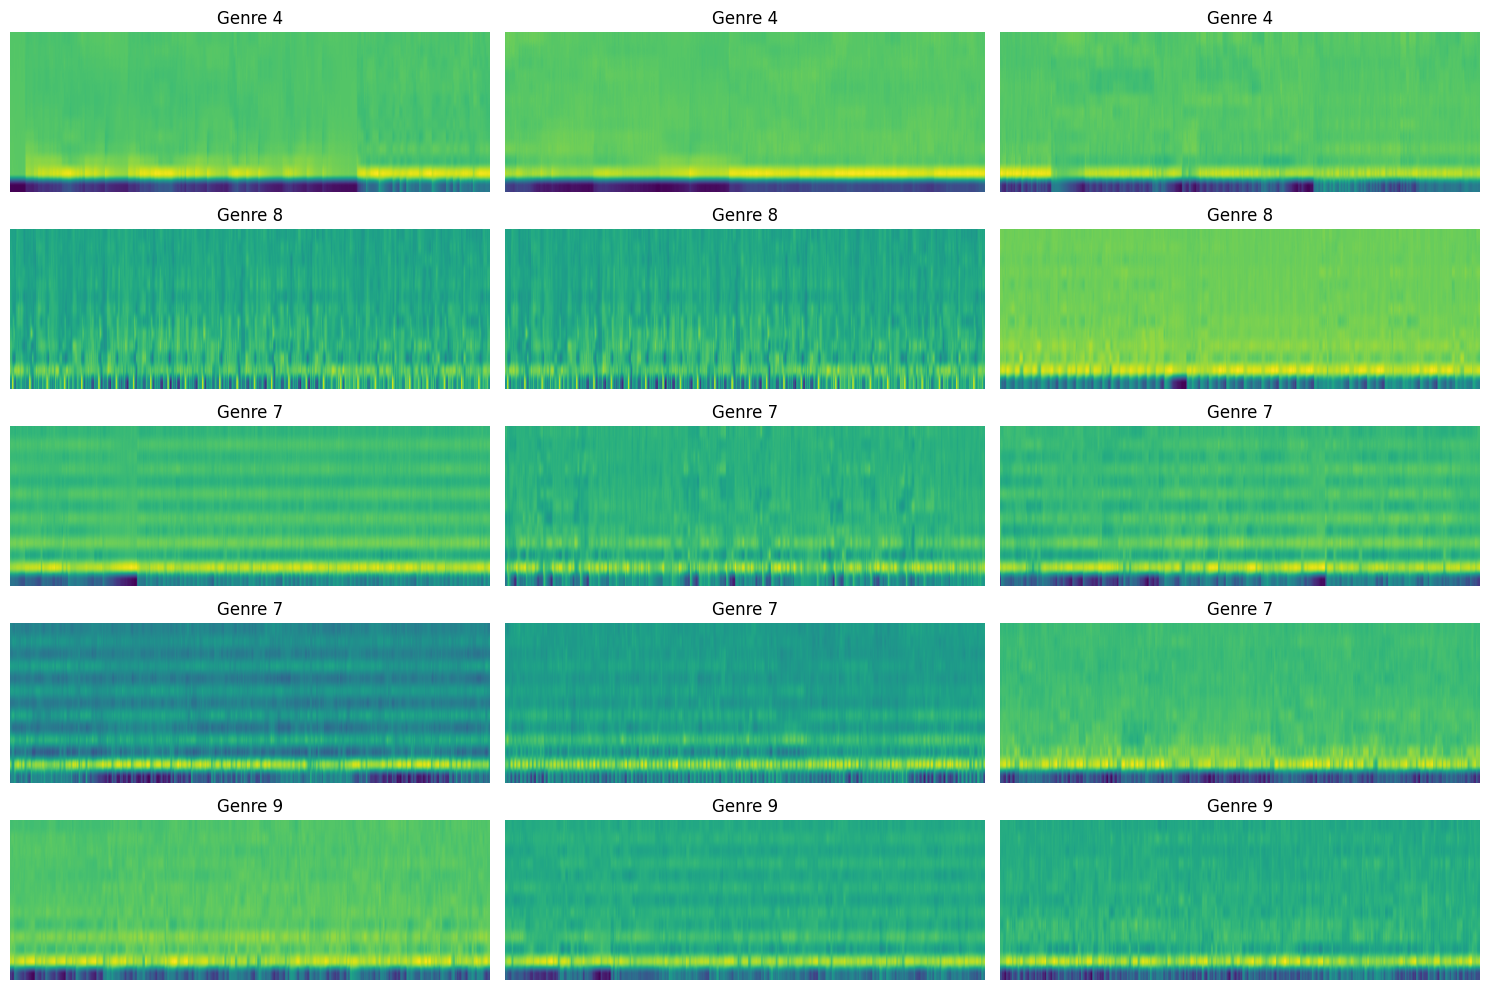

In [48]:
preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)
# Load data using the load_data function
inputs, targets = load_data(json_path=JSON_PATH)

# Visualize a few examples of MFCCs for different genres
plt.figure(figsize=(15, 10))
for i in range(5):  # Show examples for 5 genres
    genre_label = np.random.choice(np.unique(targets))
    genre_samples = inputs[targets == genre_label]

    for j in range(3):  # Show 3 samples for each genre
        sample = np.random.choice(len(genre_samples))
        mfcc = genre_samples[sample]

        plt.subplot(5, 3, i * 3 + j + 1)
        plt.imshow(mfcc.T, cmap='viridis', origin='lower', aspect='auto')
        plt.title(f'Genre {genre_label}')
        plt.axis('off')

plt.tight_layout()
plt.show()


Recursively explores directory (SOURCE_PATH) to identify audio files with a ".wav" extension. For each discovered WAV file, the script utilizes Librosa to load the audio, specifying a sampling rate of 32,000 Hz. Subsequently, it generates a waveform plot using Matplotlib, depicting the amplitude variations of the audio signal over time.

<ipython-input-50-a1691099f8d3>:25: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y, sr=sr, max_points=11025, x_axis='s')


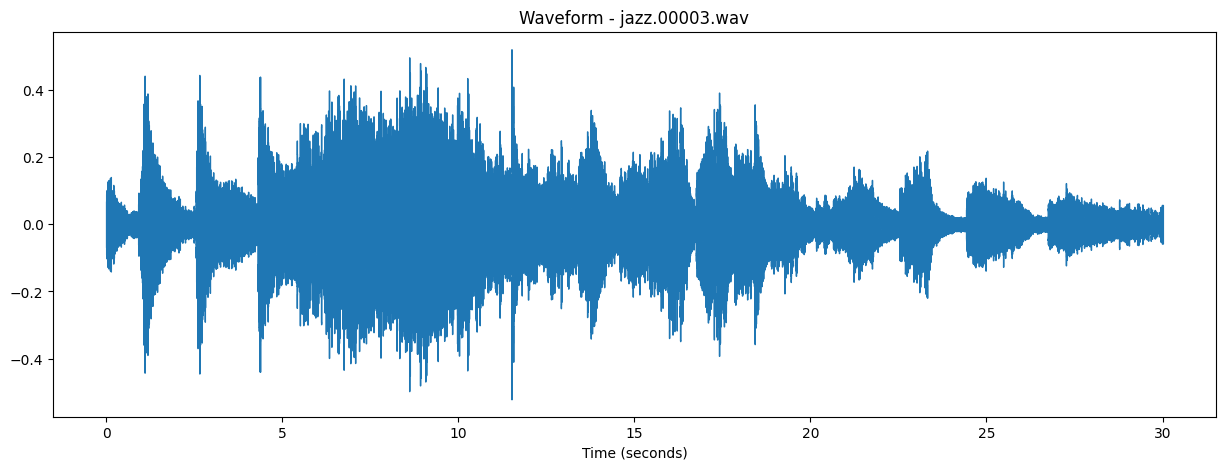

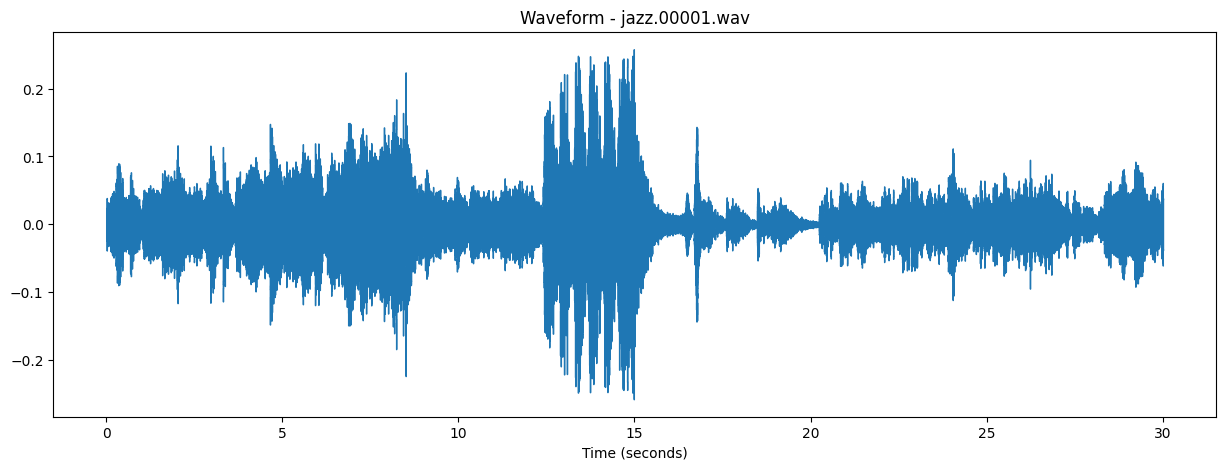

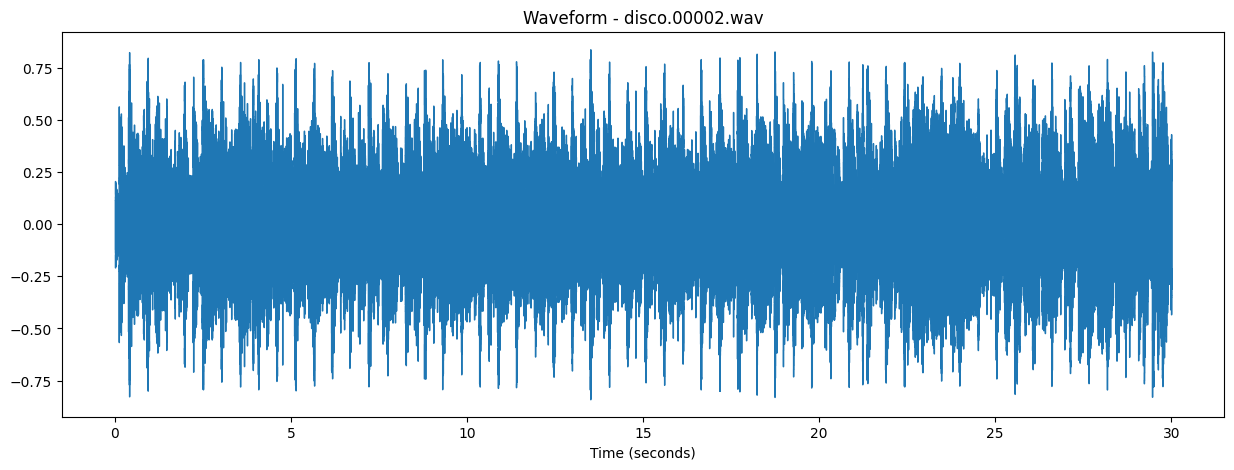

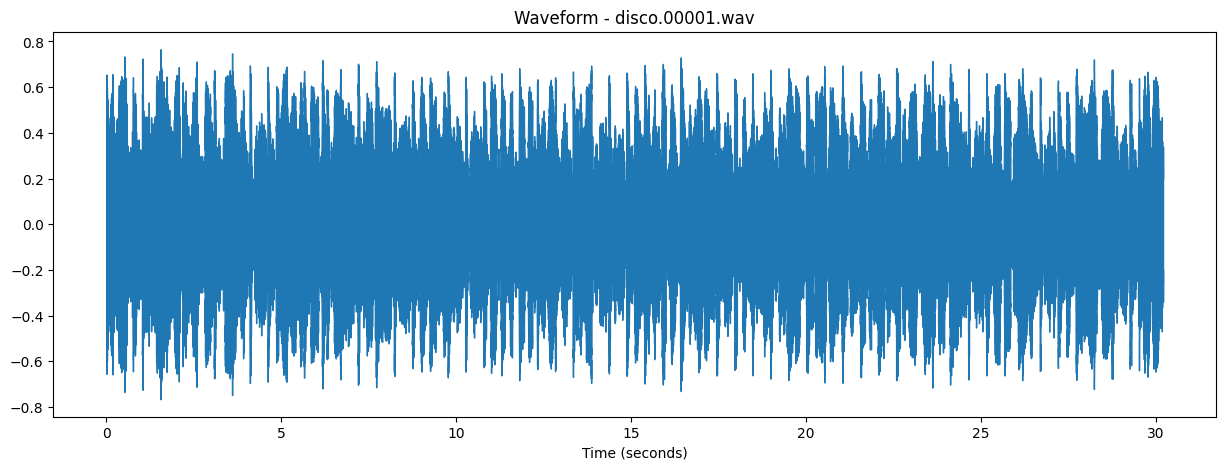

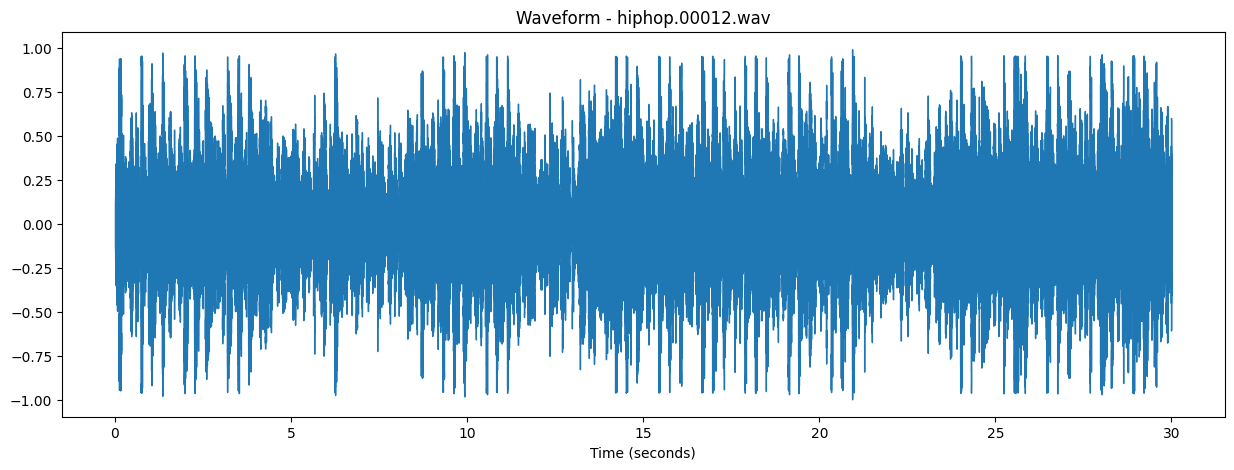

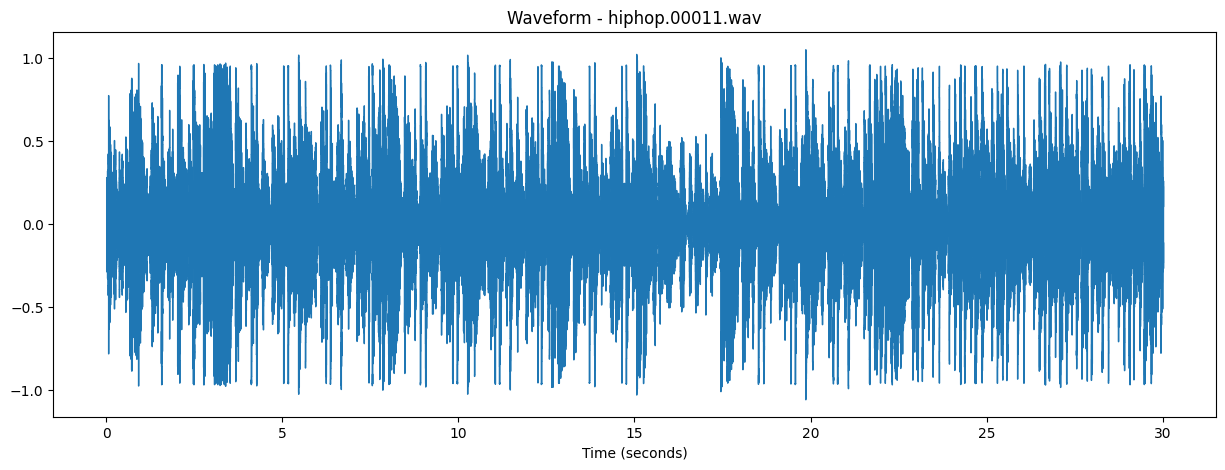

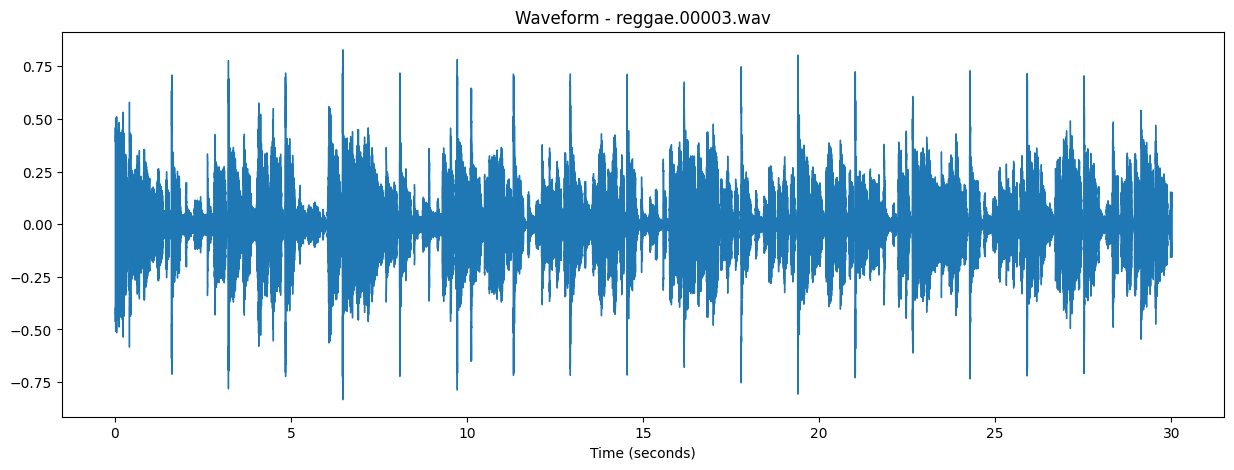

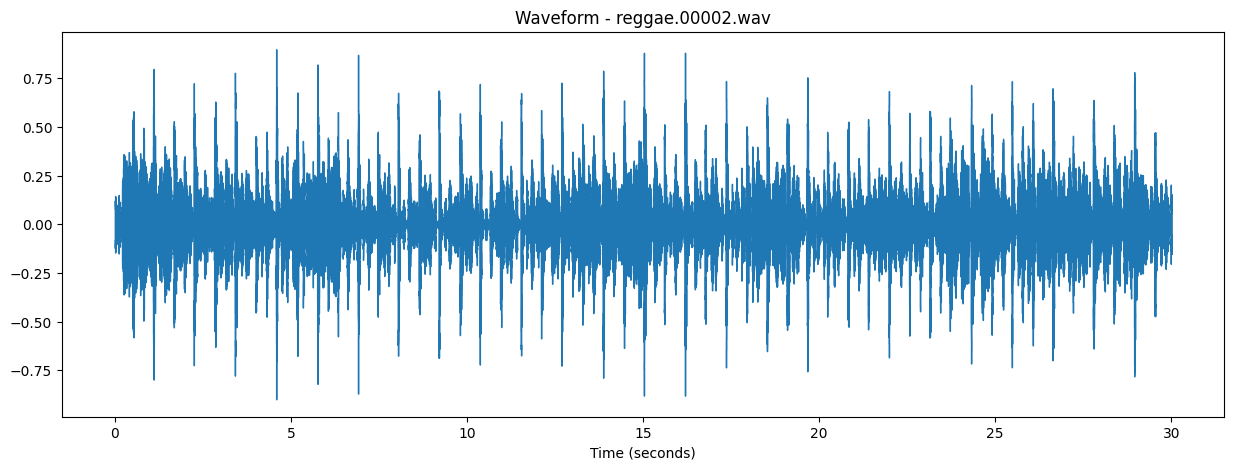

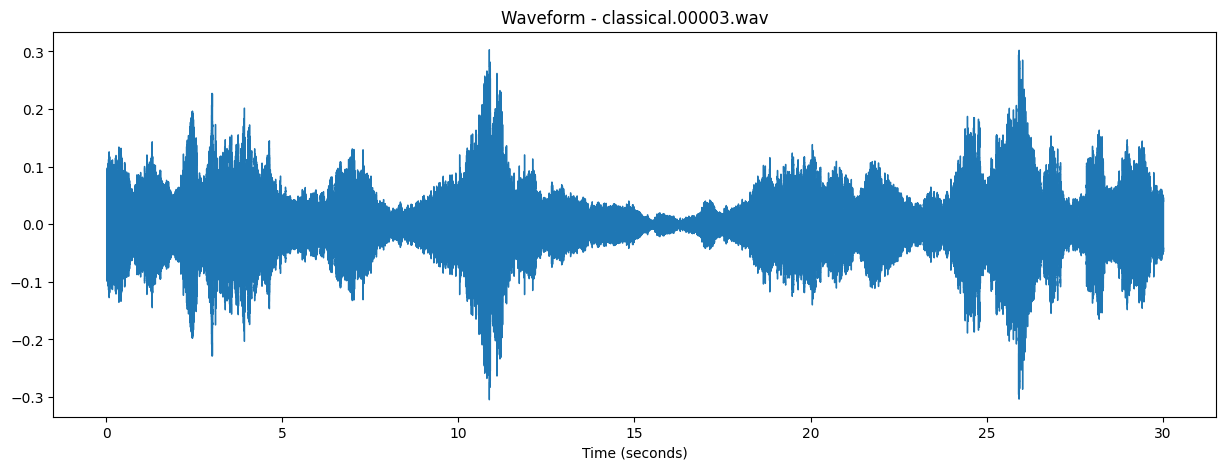

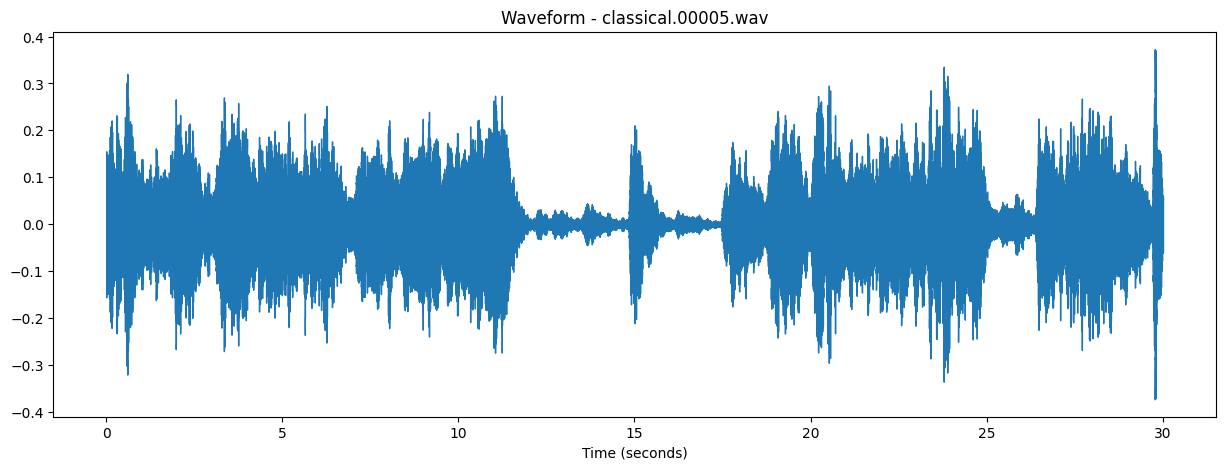

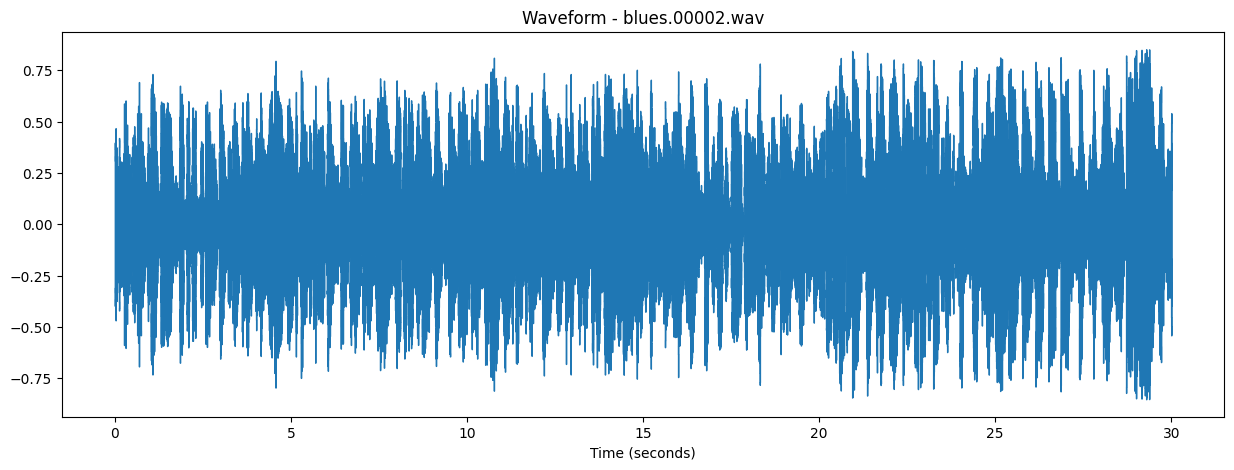

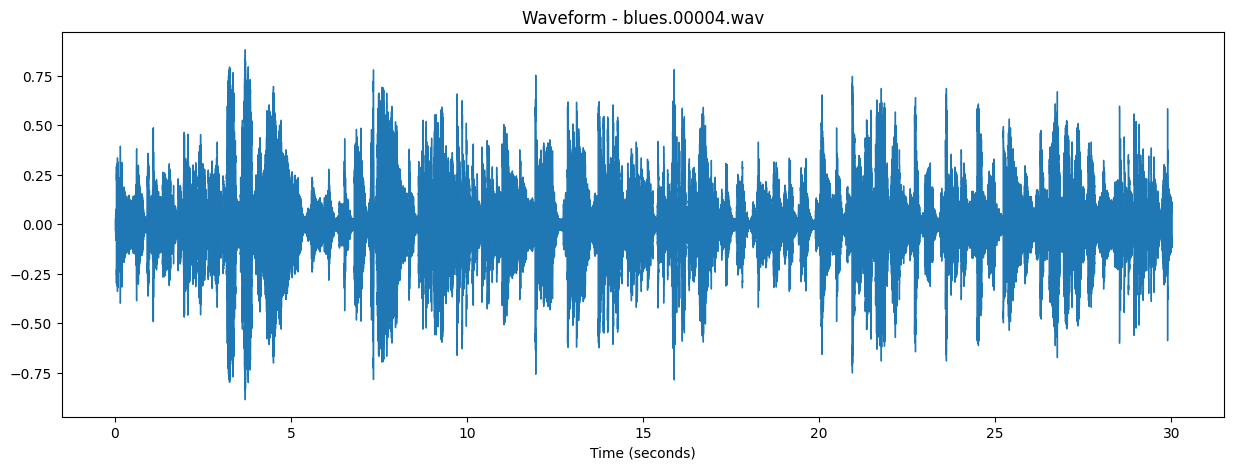

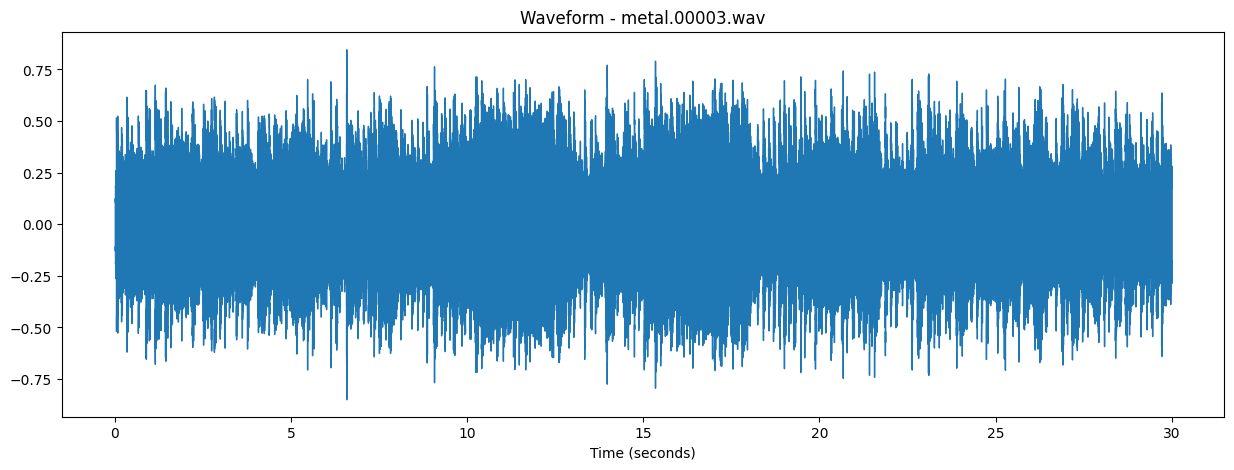

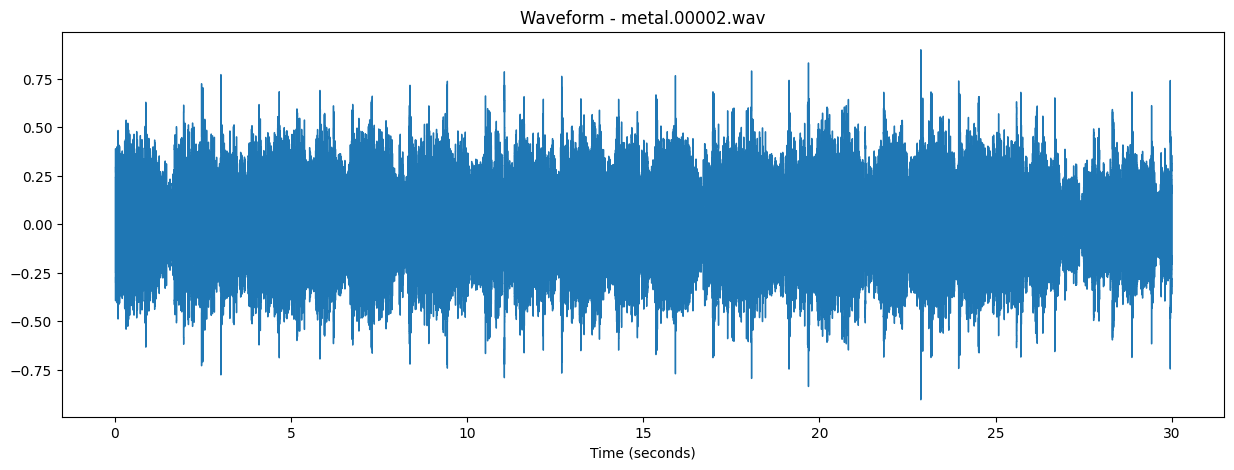

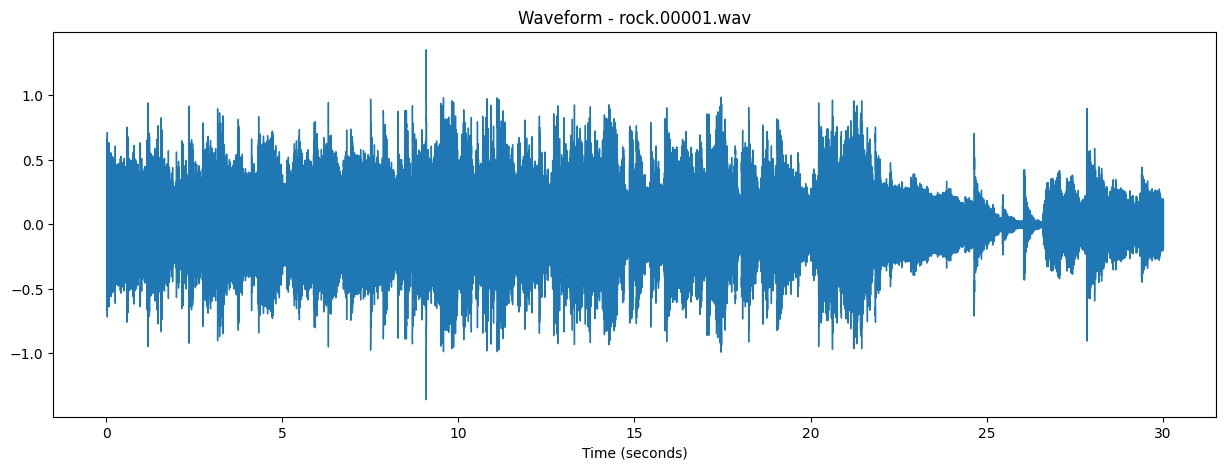

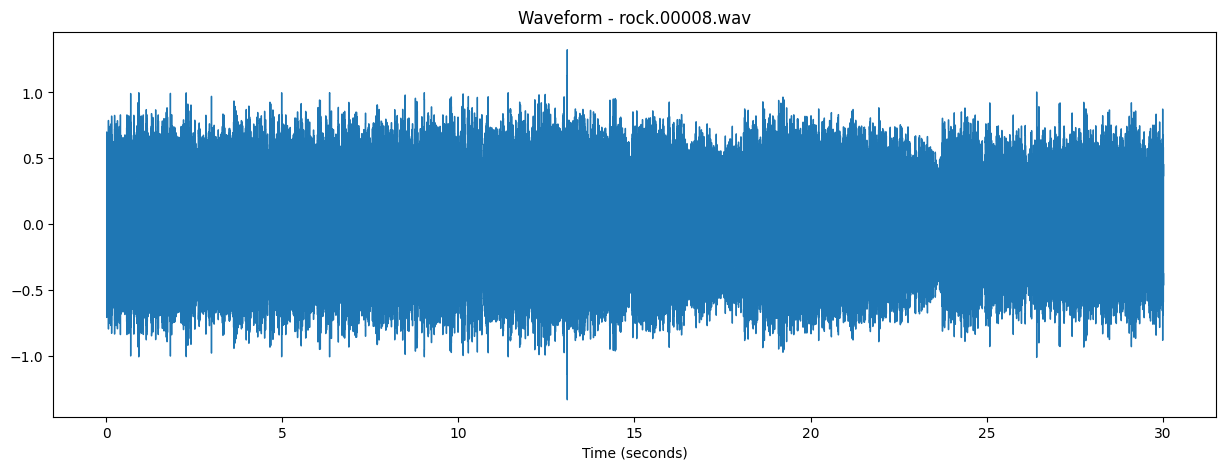

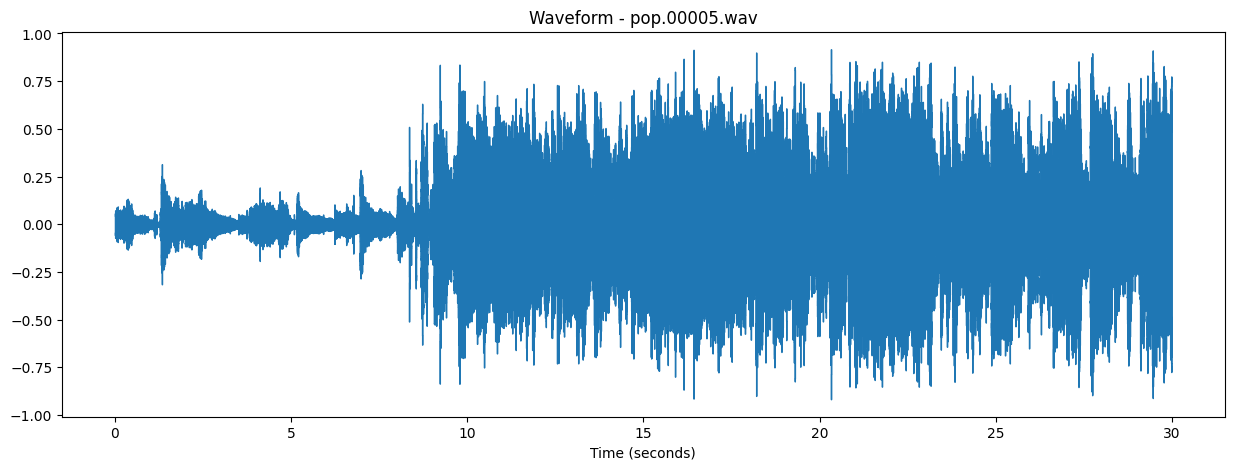

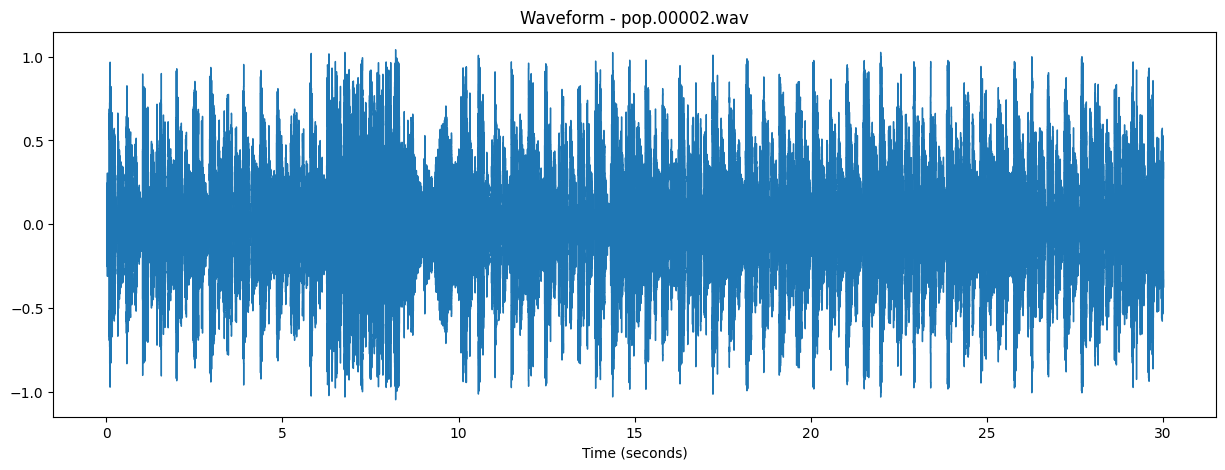

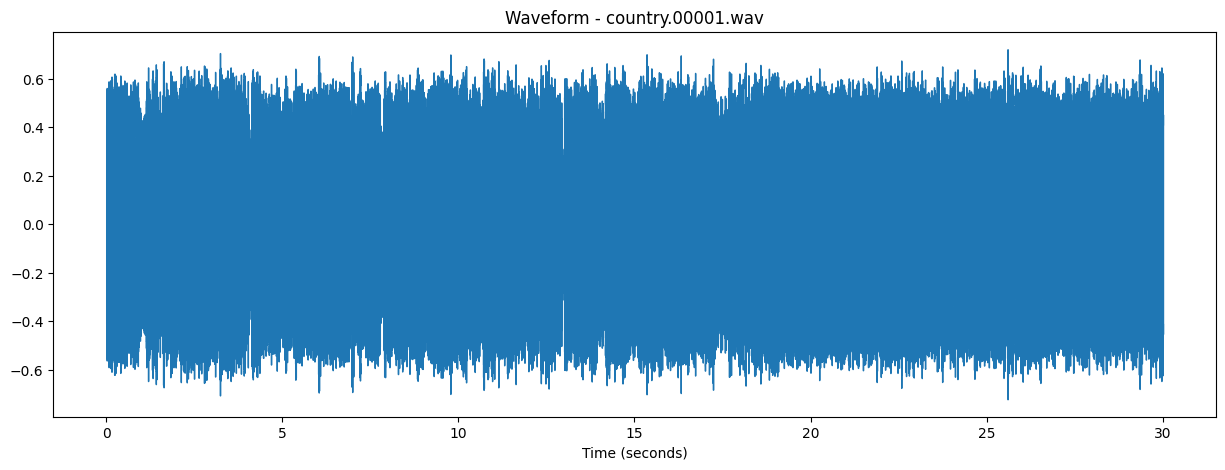

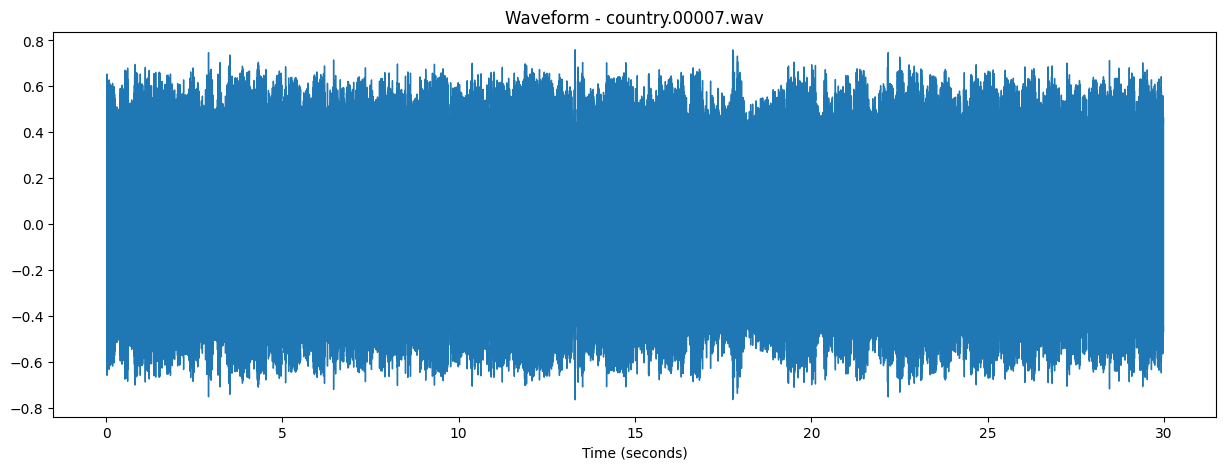

In [50]:
Max_per_folder = 2  # Set the number of files you want to display per folder

# Dictionary to keep track of processed folders
processed_folders = {}

for root, dirs, files in os.walk(SOURCE_PATH):
    # Check if the current folder has been processed
    if root not in processed_folders:
        # Add the folder to the processed folders dictionary
        processed_folders[root] = True

        # Counter variable to keep track of processed files in the current folder
        files_processed = 0

        for filename in files:
            if filename.endswith(".wav"):
                file_path = os.path.join(root, filename)

                # Load audio file
                y, sr = librosa.load(file_path, sr=32000)

                # Display waveform for the first file in the folder
                if files_processed < Max_per_folder:
                    plt.figure(figsize=(15, 5))
                    librosa.display.waveshow(y, sr=sr, max_points=11025, x_axis='s')
                    plt.title(f'Waveform - {filename}')
                    plt.show()

                    # Increment the files processed count
                    files_processed += 1
                else:
                    # If you've reached the maximum number of files to display, break the loop
                    break

The design_model2 function defines a Sequential model for music genre classification using Gated Recurrent Unit (GRU) layers. The architecture includes three GRU layers, each followed by Batch Normalization and Dropout for regularization. Two dense layers with Batch Normalization and ReLU activation are added, culminating in a final dense layer with softmax activation for multi-class classification.

In [51]:
def design_model2(input_shape):
  model = Sequential()

  # Add GRU layers
  model.add(GRU(128, input_shape=(input_shape),kernel_regularizer=l2(0.001), return_sequences=True))  # Adjust input_shape based on your data
  model.add(BatchNormalization())
  model.add(Dropout(0.5))


  model.add(GRU(128,kernel_regularizer=l2(0.001), return_sequences=True))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))


  model.add(GRU(128, kernel_regularizer=l2(0.001)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))


  model.add(Dense(64, kernel_regularizer=l2(0.001),activation = 'relu'))
  model.add(BatchNormalization())

  model.add(Dense(64,kernel_regularizer=l2(0.001), activation='relu'))
  model.add(BatchNormalization())

  # Add a dense layer for classification
  model.add(Dense(10, activation='softmax'))  # Assuming you have 10 genres

  return model

The make_prediction function takes a trained model (model), input data (X), corresponding ground truth labels (y), and an index (idx) specifying a particular sample for prediction. It utilizes a dictionary (genre_dict) to map numerical genre labels to their respective genre names. The function then performs predictions on the input data using the trained model and identifies the predicted genre by selecting the index with the highest probability. Finally, it prints the predicted genre and the actual ground truth genre for the specified sample.

In [52]:
def make_prediction(model, X, y, idx):

    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }

    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])

    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))


The provided function, plot_performance, takes a TensorFlow model training history (hist) and visualizes its performance over epochs. It extracts training and validation accuracy along with training and validation loss from the history. Using Matplotlib, it creates two subplots: one for accuracy and another for loss. In each subplot, it plots the training and validation metrics against the number of epochs, distinguishing them with red ('r') and blue ('b') lines, respectively.

In [53]:
def plot_performance(hist):

    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

The make_prediction2 function is designed for making genre predictions using a trained neural network model. Given the model and a set of input data (X), it utilizes the model's predict method to generate genre predictions for the input samples. The function then identifies the genre with the highest predicted probability using NumPy's argmax function. The predicted genre is mapped to its corresponding label using a predefined genre_dict.

In [54]:
def make_prediction2(model, X):

    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }

    predictions = model.predict(X)
    print(predictions)
    genre = np.argmax(predictions)
    print(genre)

    print("\n---Now testing the model for one audio file---\nThe model predicts: {}.\n".format(genre_dict[genre]))

 It involves preprocessing a specific audio file (hiphop.00000.wav) for prediction. The preprocess_data_prediction function loads the audio file, extracts MFCCs using Librosa, and stores the MFCC features in a dictionary (mydict). This dictionary is then written to a JSON file (PREDICTION_JSON_PATH). The load_prediction_data function loads the preprocessed data from the JSON file into NumPy arrays, specifically extracting the MFCCs (X).

In [ ]:
preprocess_data_prediction('/content/drive/My Drive/Colab Notebooks/AI/genres_original/jazz/jazz.00004.wav', PREDICTION_JSON_PATH)
preprocessed_audio = load_prediction_data(PREDICTION_JSON_PATH)




The code preprocesses audio files by extracting MFCC features and genre labels, loads the data, and splits it into training, validation, and test sets.

In [56]:
preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)

inputs, targets = load_data(json_path=JSON_PATH)

Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

# input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)

In [57]:
input_shape = (Xtrain.shape[1:])

In [58]:
# Testing the model on never seen before data.
# make_prediction(model, Xtest, ytest, 2)

Training GRU model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_21 (GRU)                (None, 1249, 128)         54912     
                                                                 
 batch_normalization_35 (Ba  (None, 1249, 128)         512       
 tchNormalization)                                               
                                                                 
 dropout_21 (Dropout)        (None, 1249, 128)         0         
                                                                 
 gru_22 (GRU)                (None, 1249, 128)         99072     
                                                                 
 batch_normalization_36 (Ba  (None, 1249, 128)         512       
 tchNormalization)                                               
                                                                 
 dropout_22 (Dropout)        (None, 1249, 128)        

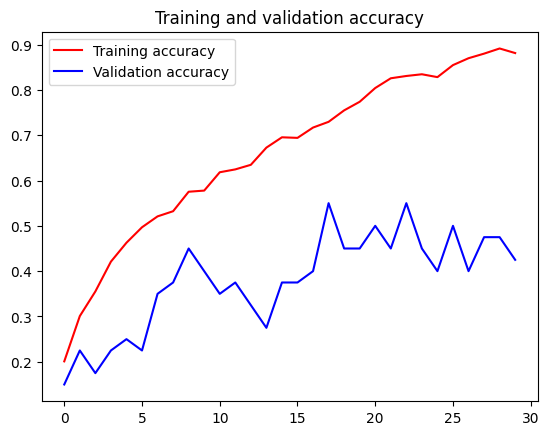

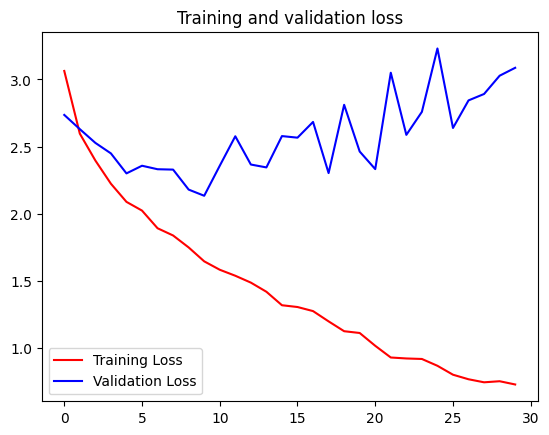

5/5 [==============================] - 3s 77ms/step

---Now testing the model for one audio file---
The model predicts: disco, and ground truth is: disco.



In [59]:
model = design_model2(input_shape)

# Selection of the optimizer, loss type and metrics for performance evaluation.
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics = ['acc']
                  )

model.summary()

#Training the model.
history = model.fit(Xtrain, ytrain,
                    validation_data=(Xval, yval),
                    epochs=30,
                    batch_size=32
                    )

plot_performance(history)




In [63]:
# Testing the model on never seen before data.
make_prediction(model, Xtest, ytest, 24)

5/5 [==============================] - 0s 70ms/step

---Now testing the model for one audio file---
The model predicts: rock, and ground truth is: disco.



Grid search for GRU

In [60]:
from sklearn.model_selection import ParameterGrid
# Define the GRU model
def create_gru_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
        # Add GRU layers
    model.add(GRU(128, input_shape=((Xtrain.shape[1], Xtrain.shape[2])),kernel_regularizer=l2(0.001), return_sequences=True))  # Adjust input_shape based on your data
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(GRU(128,kernel_regularizer=l2(0.001), return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(GRU(128, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(64, kernel_regularizer=l2(0.001),activation = 'relu'))
    model.add(BatchNormalization())

    model.add(Dense(64,kernel_regularizer=l2(0.001), activation='relu'))
    model.add(BatchNormalization())

    # Add a dense layer for classification
    model.add(Dense(10, activation='softmax'))  # Assuming you have 10 genres
    model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics = ['acc']
                  )
    return model

# Define hyperparameter grid
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.5],
    'learning_rate': [0.001, 0.01]
}

# Generate combinations of hyperparameters
grid = ParameterGrid(param_grid)



Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.001, 'units': 50}


Validation Accuracy: 0.5063291192054749
Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.001, 'units': 100}


Validation Accuracy: 0.5
Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.001, 'units': 150}


Validation Accuracy: 0.49367088079452515
Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.01, 'units': 50}


Validation Accuracy: 0.4683544337749481
Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.01, 'units': 100}


Validation Accuracy: 0.4873417615890503
Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.01, 'units': 150}


Validation Accuracy: 0.5316455960273743
Best Hyperparameters: {'dropout_rate': 0.5, 'learning_rate': 0.01, 'units': 150}
Best Validation Accuracy: 0.5316455960273743


In [66]:
# Perform grid search
best_accuracy = 0
best_params = None
best_model= None

for params in grid:
    print("Training model with parameters:", params)
    model = create_gru_model(**params)
    model.fit(Xtrain, ytrain, epochs=10, batch_size=32, validation_data=(Xval, yval), verbose=0)

    # Evaluate the model
    _, accuracy = model.evaluate(Xtest, ytest, verbose=0)

    print("Validation Accuracy:", accuracy)

    # Check if the current set of hyperparameters gives a better accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model=model


print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.001, 'units': 50}


Validation Accuracy: 0.5569620132446289
Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.001, 'units': 100}


Validation Accuracy: 0.4683544337749481
Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.001, 'units': 150}


Validation Accuracy: 0.5126582384109497
Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.01, 'units': 50}


Validation Accuracy: 0.5696202516555786
Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.01, 'units': 100}


Validation Accuracy: 0.5443037748336792
Training model with parameters: {'dropout_rate': 0.5, 'learning_rate': 0.01, 'units': 150}


Validation Accuracy: 0.4683544337749481
Best Hyperparameters: {'dropout_rate': 0.5, 'learning_rate': 0.01, 'units': 50}
Best Validation Accuracy: 0.5696202516555786


Classifying a random audio using the first model

In [70]:
make_prediction2(model, preprocessed_audio)

1/1 [==============================] - 1s 1s/step
[[9.9490190e-01 2.9593635e-05 2.6326474e-05 1.8321030e-04 2.9877713e-03
  9.1971655e-04 1.1198662e-04 3.5702271e-04 5.5062243e-05 4.2727171e-04]]
0

---Now testing the model for one audio file---
The model predicts: blues.



Classifying a random audio on the best model

In [68]:
make_prediction2(best_model, preprocessed_audio)

1/1 [==============================] - 0s 81ms/step
[[9.2418194e-01 3.1008571e-05 7.1926908e-05 3.6471471e-04 6.6906055e-03
  5.8341883e-02 1.2368351e-03 4.4134003e-03 3.0759413e-04 4.3602879e-03]]
0

---Now testing the model for one audio file---
The model predicts: blues.



Since the first model is better in than the model from the grid search, we are saving the better model to use in deployment

In [69]:
model.save("Final_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
